In [1]:
install.packages("clevr")

package 'clevr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Jayanth Shreekumar\AppData\Local\Temp\RtmpWGdkPL\downloaded_packages


In [2]:
library(igraph)
library(clevr)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'clevr' was built under R version 3.6.3"

In [3]:
companysectors <- read.csv(file = './finance_data/Name_sector.csv')
stocks <- paste("./finance_data/data", list.files("./finance_data/data", pattern="*.csv"), sep="/")

# DAILY DATA

In [4]:
l<-c()
i<-1
counts<-c()
print(sprintf("Number of companies :%s",length(stocks)))
to_delete=0
for(stock in c(1:length(stocks))) {
    company = read.csv(stocks[stock])
    counts[stock] = dim(company)[1]
    if(dim(company)[1]!=765) {
        to_delete=to_delete+1
    }
}
print(sprintf("Number of companies with missing daily data: %s",to_delete))
r = matrix(0, 494, 764)
for(stock in 1:length(stocks)){
    company = read.csv(stocks[stock])
    l[stock] = dim(company)[1]
    if(l[stock]==765){
        closing_price = company[,5]
        returns = c()
        log_normalized_return = c()
        for(t in 2:length(closing_price)){
            returns[t - 1] = (closing_price[t] - closing_price[t - 1]) / closing_price[t - 1]
        }
        log_normalized_return = log(1 + returns)
        r[i,] = log_normalized_return
        i = i + 1
    }
}

dailycompanysectors <- companysectors[c(which(l == 765)),]

[1] "Number of companies :505"
[1] "Number of companies with missing daily data: 11"


In [5]:
create_graph <- function(file_name, r, companysectors) {
  company_1 <- c()
  company_2 <- c()
  weight <- c()
  for(i in 1:(dim(r)[1] - 1)){
    for(j in (i+1):(dim(r)[1])){
      r_i <- mean(r[i,])
      r_j <- mean(r[j,])
      r_i_squared <- r[i,] ^ 2
      r_j_squared <- r[j,] ^ 2
      rho_ij <- ((mean(r[i,] * r[j,]))-(r_i * r_j))/(sqrt((mean(r_i_squared) - (r_i ^ 2)) * (mean(r_j_squared) - (r_j ^ 2))))
      w_ij <- sqrt(2 * (1 - rho_ij))
      company_1 <- append(company_1, companysectors[i,1])
      company_2 <- append(company_2, companysectors[j,1])
      weight <- append(weight, w_ij)
    }
  }
  df <- data.frame(Start = company_1, End = company_2, Weight = weight)
  write.csv(df, file_name, row.names = FALSE)
}

In [6]:
minimum_spanning_tree_fn <- function(companysectors, graph, s) {

    minimum_spanning_tree = mst(graph)

    colors = list("Health Care"="blue",
                  "Industrials"="green",
                  "Consumer Discretionary"="blueviolet",
                  "Information Technology"="gold",
                  "Consumer Staples"="orange",
                  "Utilities"="purple",
                  "Financials"="red",
                  "Real Estate"="yellow",
                  "Materials"="azure",
                  "Energy"="chartreuse",
                  "Telecommunication Services"="deeppink")

    color_map = c()
    for(v in 1:vcount(graph)){
        sector = companysectors[v,2]
        color_map[v] = colors[[sector]]
    }

    plot(minimum_spanning_tree,vertex.size=3, vertex.label=NA, 
         vertex.color=color_map, main=sprintf("Minimum Spanning Tree for %s Data", s), 
         layout=layout.reingold.tilford(minimum_spanning_tree,circular=T))
    
    return(minimum_spanning_tree)
}

QUESTION 2

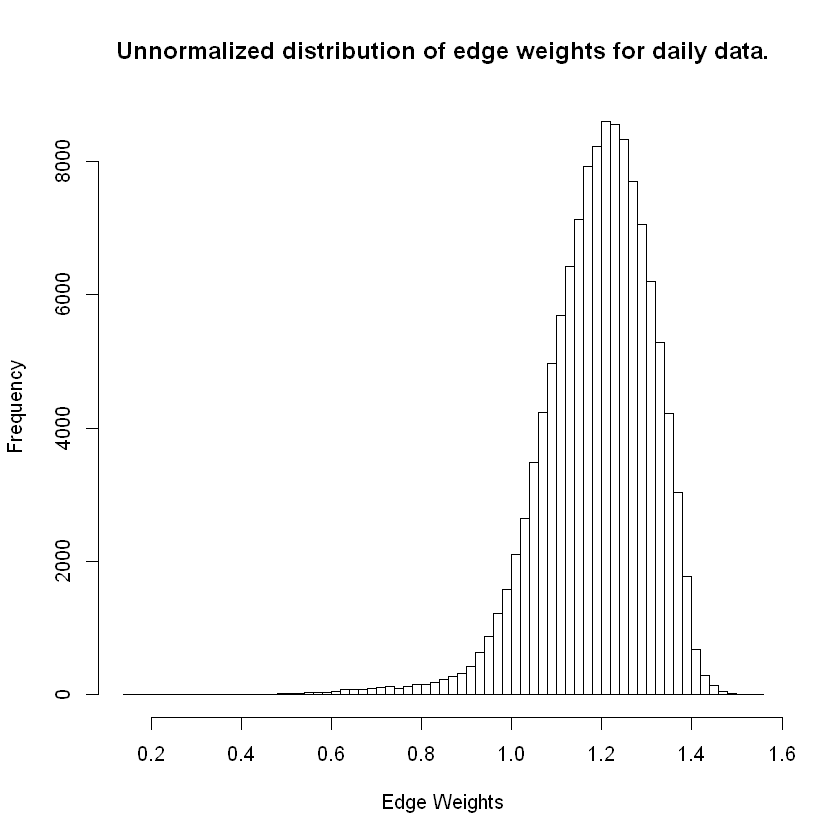

In [7]:
create_graph("./finance_data/edges_daily.csv", r, dailycompanysectors)
edges= read.csv("./finance_data/edges_daily.csv")
dailygraph = graph.data.frame(edges, directed = FALSE)
E(dailygraph)$weight = edges[,"Weight"]
hist(edges[,"Weight"],breaks=50,
     main="Unnormalized distribution of edge weights for daily data.",
     xlab="Edge Weights",
     ylab="Frequency")

QUESTION 3

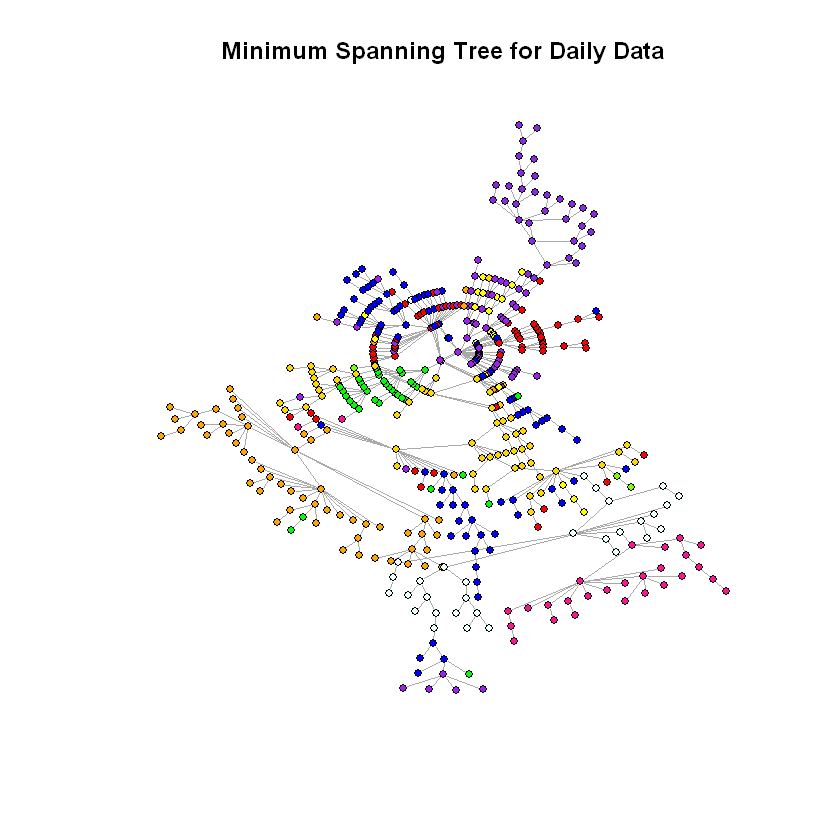

In [8]:
daily_mst = minimum_spanning_tree_fn(dailycompanysectors, dailygraph, "Daily")

QUESTION 4

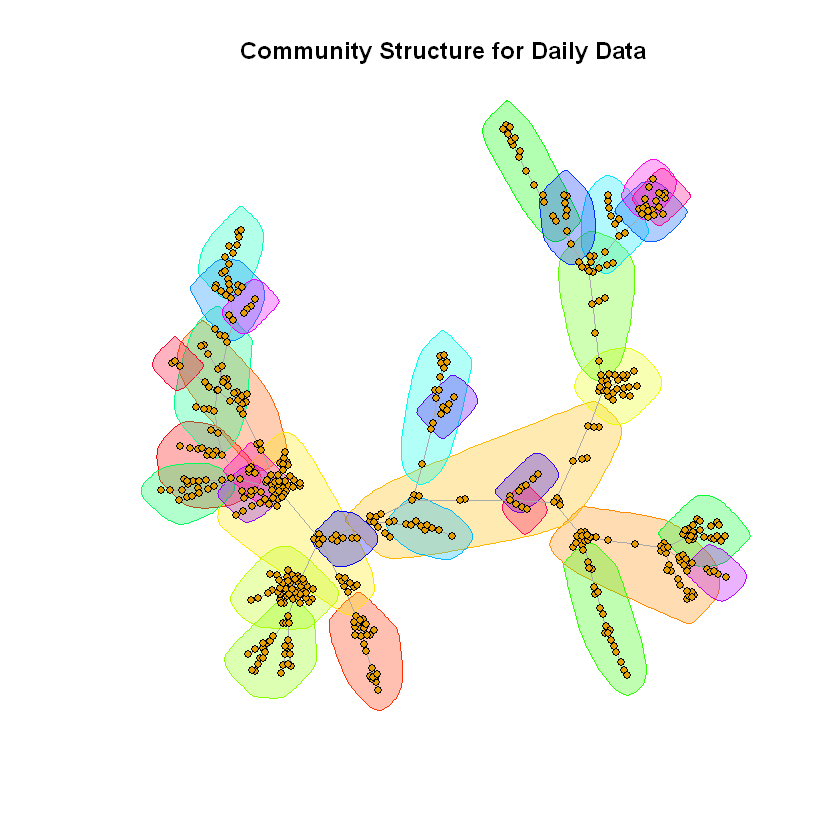

In [9]:
node_community_daily = cluster_walktrap(
  daily_mst,
  modularity = TRUE,
  membership = TRUE
)
plot(daily_mst,
    mark.groups = groups(node_community_daily),
    vertex.size=3,
    vertex.label=NA,
    main="Community Structure for Daily Data"
    )

In [10]:
pred <- membership(node_community_daily)
pred <- as.numeric(pred)

factor <- factor(dailycompanysectors[, "Sector"])
true <- as.numeric(factor)

In [11]:
completeness(true, pred)

[1] 0.4792845

In [12]:
homogeneity(true, pred)

[1] 0.6826446

QUESTION 5

In [13]:
unique_sectors = unique(dailycompanysectors[,2])
S <- c()
for(i in c(1:length(unique_sectors))){
  S[i] <- length(which(dailycompanysectors[,2]==unique_sectors[i]))
}
pred1 <- c()

vertices_count <- vcount(daily_mst)

for(vertex in c(1:vertices_count)){
  neighbors <- neighbors(daily_mst,vertex)
  Qi<-0
  for(i in neighbors){
    if(dailycompanysectors[i,2]==dailycompanysectors[vertex,2])
      Qi<-Qi+1
  }
  Ni <- length(neighbors)
  pred1[vertex] <- Qi/Ni
}

alpha1 <- sum(pred1)/vertices_count
print(sprintf("Value of alpha1: %f",alpha1))

[1] "Value of alpha1: 0.828930"


In [14]:
pred2 <- c()
for(vertex in c(1:vertices_count)){
    pred2[vertex] <- S[which(unique_sectors==dailycompanysectors[vertex,2])]/vertices_count
}

alpha2 <- sum(pred2)/vertices_count

print(sprintf("Value of alpha2: %f",alpha2))

[1] "Value of alpha2: 0.114188"


# WEEKLY DATA

In [15]:
l<-c()
i<-1
to_delete=0
counts<-c()
print(sprintf("Number of companies :%s",length(stocks)))
for(stock in c(1:length(stocks))) {
    company = read.csv(stocks[stock])
    company["Day"] = weekdays(as.Date(company[,1]))
    company = subset(company, Day=='Monday')
    counts[stock] = dim(company)[1]
    if(dim(company)[1]!=143) {
        to_delete=to_delete+1
    }
}
print(sprintf("Number of companies with missing weekly data: %s",to_delete)) 
r = matrix(0, 492, 142)
for(stock in 1:length(stocks)){
    company = read.csv(stocks[stock])
    company["Day"]=weekdays(as.Date(company[,1])) 
    company =subset(company, Day=='Monday')
    l[stock] = dim(company)[1]
    if(l[stock]==143){
        closing_price = company[,5]
        returns = c()
        log_normalized_return = c()
        for(t in 2:length(closing_price)){
            returns[t - 1] = (closing_price[t] - closing_price[t - 1]) / closing_price[t - 1]
        }
        log_normalized_return = log(1 + returns)
        r[i,] = log_normalized_return
        i = i + 1
    }
}

weeklycompanysectors <- companysectors[c(which(l == 143)),]

[1] "Number of companies :505"
[1] "Number of companies with missing weekly data: 13"


QUESTION 2

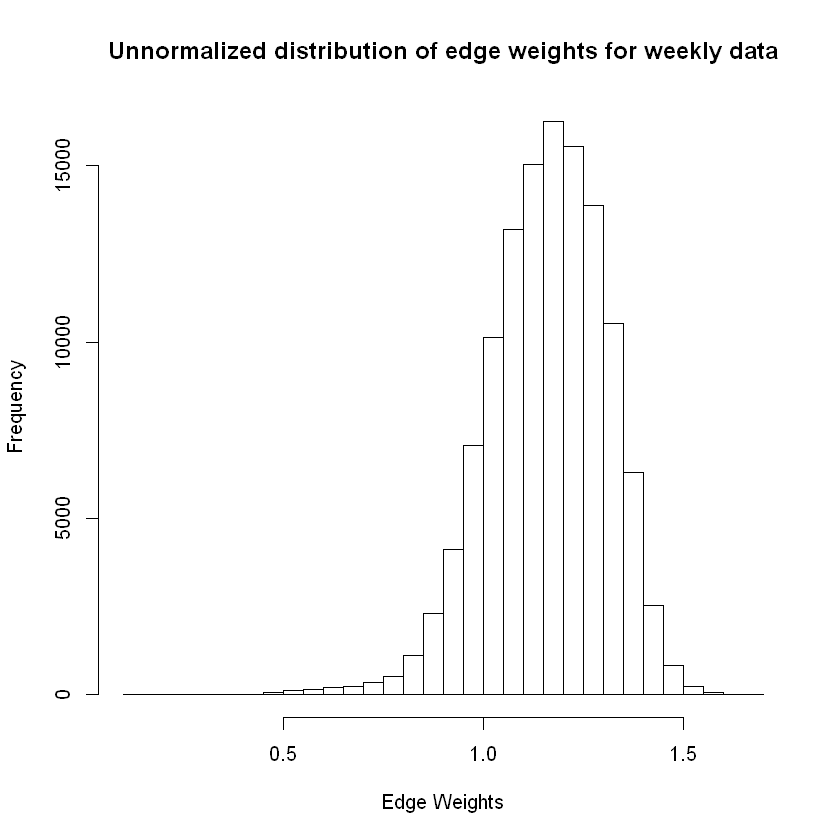

In [16]:
create_graph("./finance_data/edges_weekly.csv", r, weeklycompanysectors)
edges= read.csv("./finance_data/edges_weekly.csv")
weeklygraph = graph.data.frame(edges, directed = FALSE)
E(weeklygraph)$weight = edges[,"Weight"]
hist(edges[,"Weight"],breaks=50,
     main="Unnormalized distribution of edge weights for weekly data",
     xlab="Edge Weights",
     ylab="Frequency")

QUESTION 3

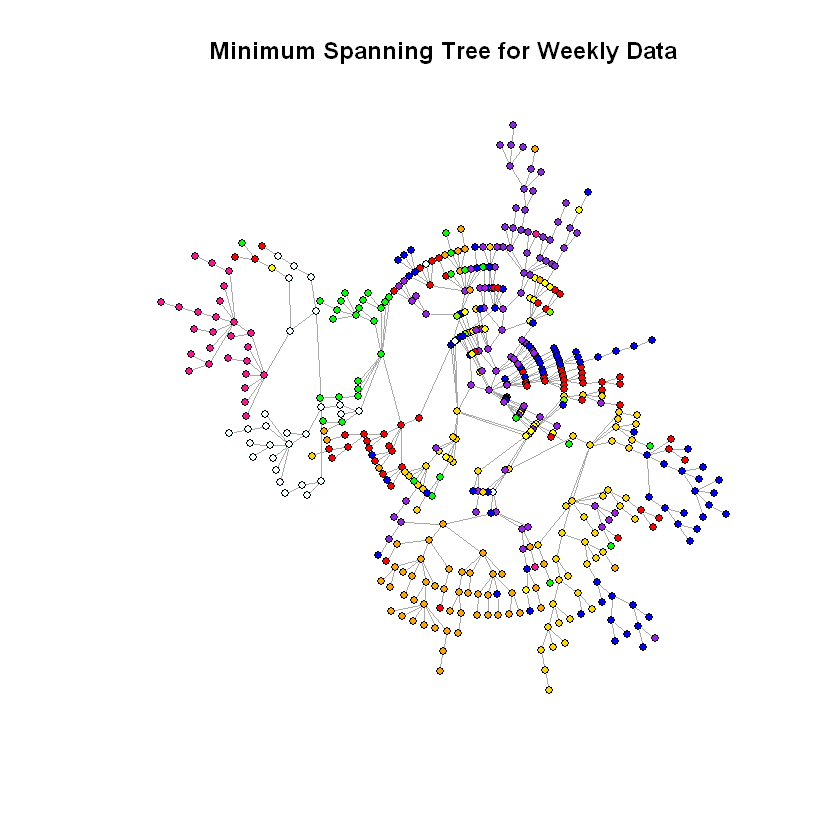

In [17]:
weekly_mst = minimum_spanning_tree_fn(weeklycompanysectors, weeklygraph, "Weekly")

QUESTION 4

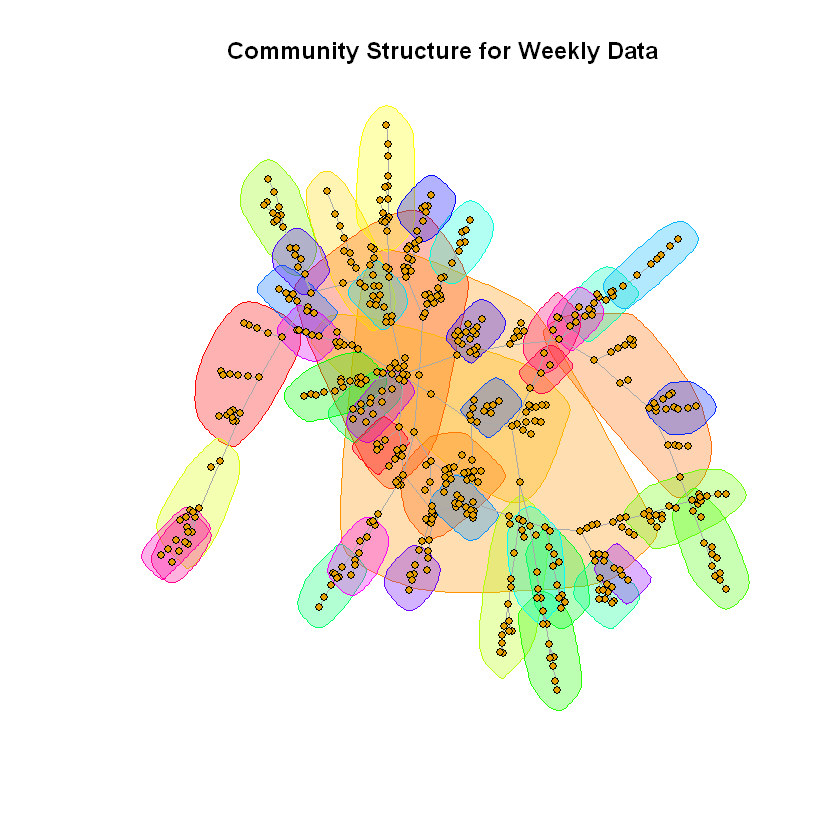

In [18]:
node_community_weekly = cluster_walktrap(
  weekly_mst,
  modularity = TRUE,
  membership = TRUE
)
plot(weekly_mst,
    mark.groups = groups(node_community_weekly),
    vertex.size=3,
    vertex.label=NA,
    main="Community Structure for Weekly Data"
    )

In [19]:
pred <- membership(node_community_weekly)
pred <- as.numeric(pred)

factor <- factor(weeklycompanysectors[, "Sector"])
true <- as.numeric(factor)

In [20]:
completeness(true, pred)

[1] 0.3900435

In [21]:
homogeneity(true, pred)

[1] 0.5811237

QUESTION 5

In [22]:
unique_weekly_sectors = unique(weeklycompanysectors[,2])
S <- c()
for(i in c(1:length(unique_sectors))){
  S[i] <- length(which(weeklycompanysectors[,2]==unique_weekly_sectors[i]))
}
pred1 <- c()

vertices_count <- vcount(weekly_mst)

for(vertex in c(1:vertices_count)){
  neighbors <- neighbors(weekly_mst,vertex)
  Qi<-0
  for(i in neighbors){
    if(weeklycompanysectors[i,2]==weeklycompanysectors[vertex,2])
      Qi<-Qi+1
  }
  Ni <- length(neighbors)
  pred1[vertex] <- Qi/Ni
}

alpha1 <- sum(pred1)/vertices_count
print(sprintf("Value of alpha1: %f",alpha1))

[1] "Value of alpha1: 0.743957"


In [23]:
pred2 <- c()
for(vertex in c(1:vertices_count)){
    pred2[vertex] <- S[which(unique_sectors==weeklycompanysectors[vertex,2])]/vertices_count
}

alpha2 <- sum(pred2)/vertices_count

print(sprintf("Value of alpha2: %f",alpha2))

[1] "Value of alpha2: 0.114309"


# MONTHLY DATA

In [24]:
l<-c()
i<-1
to_delete=0
counts<-c()
print(sprintf("Number of companies :%s",length(stocks)))
for(stock in c(1:length(stocks))) {
    company = read.csv(stocks[stock])
    company$Date <- as.Date(company$Date, '%Y-%m-%d')
    company <- subset(company, format(Date, '%d') == '15')
    counts[stock] = dim(company)[1]
    if(dim(company)[1]!=25) {
        to_delete=to_delete+1
    }
}
print(sprintf("Number of companies with missing monthly data: %s",to_delete)) 
r = matrix(0, 492, 24)
for(stock in 1:length(stocks)){
    company = read.csv(stocks[stock])
    company$Date <- as.Date(company$Date, '%Y-%m-%d')
    company <- subset(company, format(Date, '%d') == '15')
    l[stock] = dim(company)[1]
    if(l[stock]==25){
        closing_price = company[,5]
        returns = c()
        log_normalized_return = c()
        for(t in 2:length(closing_price)){
            returns[t - 1] = (closing_price[t] - closing_price[t - 1]) / closing_price[t - 1]
        }
        log_normalized_return = log(1 + returns)
        r[i,] = log_normalized_return
        i = i + 1
    }
}

monthlycompanysectors <- companysectors[c(which(l == 25)),]

[1] "Number of companies :505"
[1] "Number of companies with missing monthly data: 13"


QUESTION 2

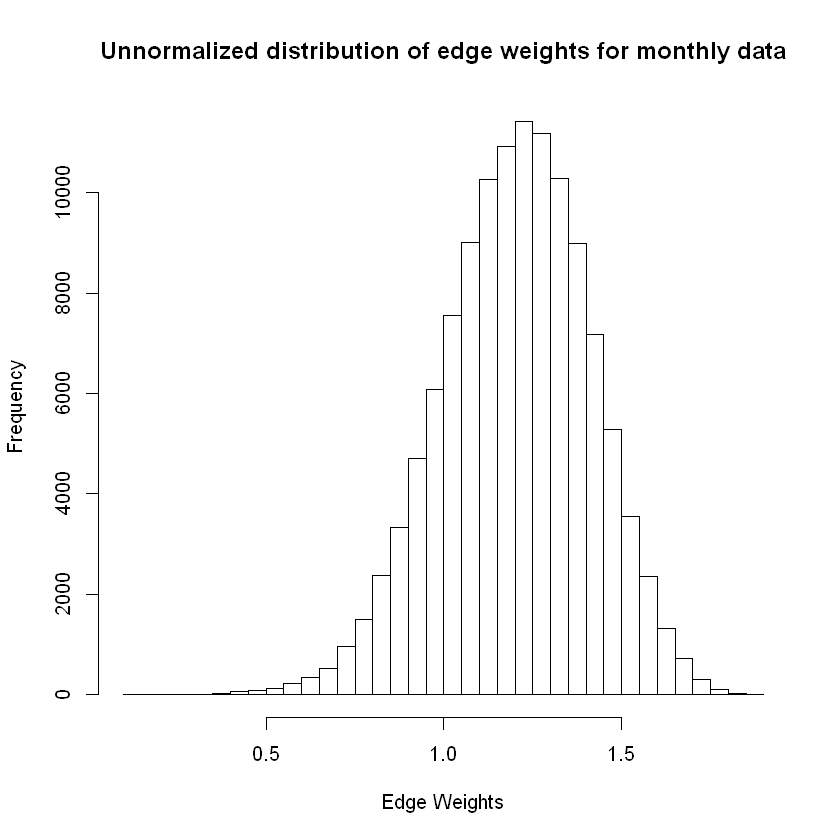

In [25]:
create_graph("./finance_data/edges_monthly.csv", r, monthlycompanysectors)
edges= read.csv("./finance_data/edges_monthly.csv")
monthlygraph = graph.data.frame(edges, directed = FALSE)
E(monthlygraph)$weight = edges[,"Weight"]
hist(edges[,"Weight"],breaks=50,
     main="Unnormalized distribution of edge weights for monthly data",
     xlab="Edge Weights",
     ylab="Frequency")

QUESTION 3

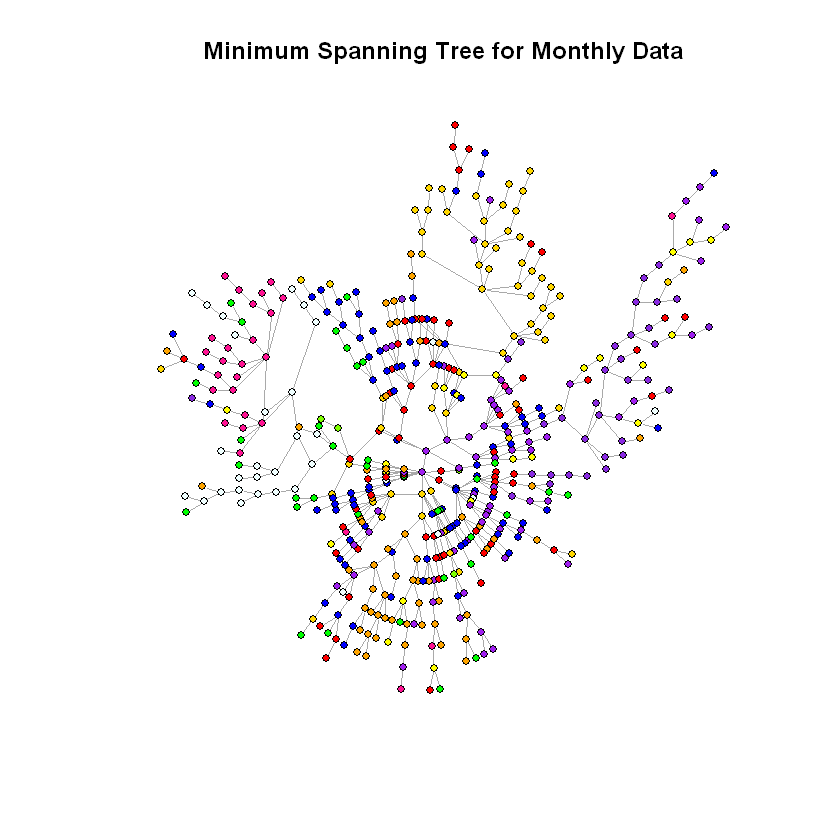

In [26]:
monthly_mst = minimum_spanning_tree_fn(monthlycompanysectors, monthlygraph, "Monthly")

QUESTION 4

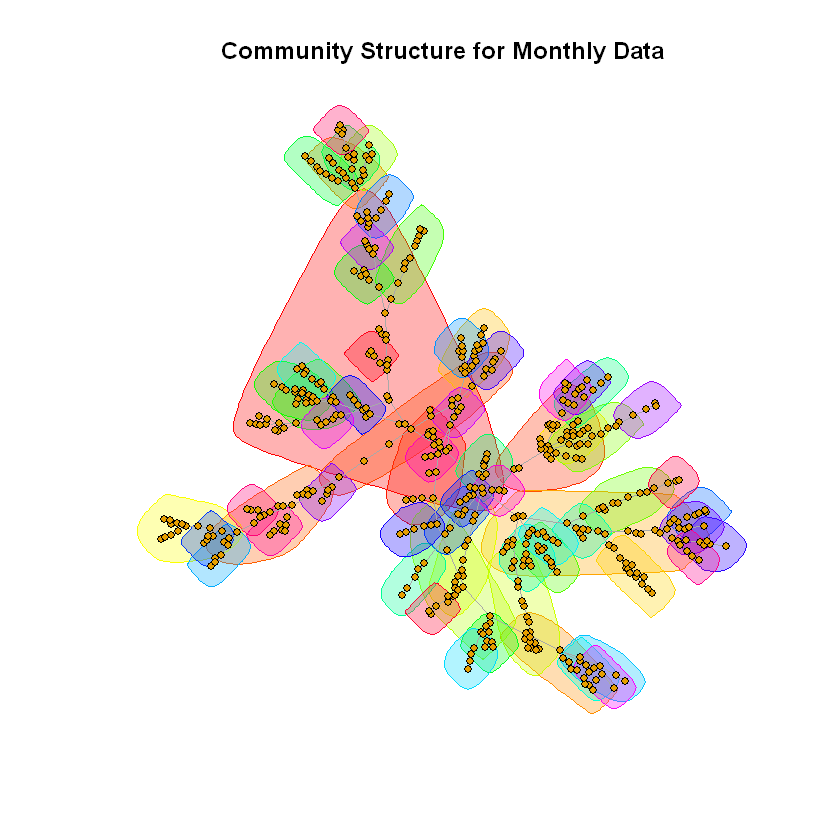

In [27]:
node_community_monthly = cluster_walktrap(
  monthly_mst,
  modularity = TRUE,
  membership = TRUE
)
plot(monthly_mst,
    mark.groups = groups(node_community_monthly),
    vertex.size=3,
    vertex.label=NA,
    main="Community Structure for Monthly Data"
    )

In [28]:
pred <- membership(node_community_monthly)
pred <- as.numeric(pred)

factor <- factor(monthlycompanysectors[, "Sector"])
true <- as.numeric(factor)

In [29]:
completeness(true, pred)

[1] 0.2775512

In [30]:
homogeneity(true, pred)

[1] 0.4794473

QUESTION 5

In [31]:
unique_monthly_sectors = unique(monthlycompanysectors[,2])
S <- c()
for(i in c(1:length(unique_sectors))){
  S[i] <- length(which(monthlycompanysectors[,2]==unique_monthly_sectors[i]))
}
pred1 <- c()

vertices_count <- vcount(monthly_mst)

for(vertex in c(1:vertices_count)){
  neighbors <- neighbors(monthly_mst,vertex)
  Qi<-0
  for(i in neighbors){
    if(monthlycompanysectors[i,2]==monthlycompanysectors[vertex,2])
      Qi<-Qi+1
  }
  Ni <- length(neighbors)
  pred1[vertex] <- Qi/Ni
}

alpha1 <- sum(pred1)/vertices_count
print(sprintf("Value of alpha1: %f",alpha1))

[1] "Value of alpha1: 0.484446"


In [32]:
pred2 <- c()
for(vertex in c(1:vertices_count)){
    pred2[vertex] <- S[which(unique_sectors==monthlycompanysectors[vertex,2])]/vertices_count
}

alpha2 <- sum(pred2)/vertices_count

print(sprintf("Value of alpha2: %f",alpha2))

[1] "Value of alpha2: 0.114309"
